# Tutorial 3 - Create Training Labels
#### This is the third tutorial of a series of step-by-step walkthroughs of Yolo algorithm

In this tutorial, we are going to focus on **YOLO2**, which is simpler to understand and easier to explain comparing to its sucessors. If you are looking for YOLO3/4, I still encourage you to understand YOLO2 first as later modifications are **very similar** to YOLO2 in terms of detection logics.

In [1]:
#some boilerplate code
import tensorflow as tf
import os, glob
import numpy as np
from xml.etree import ElementTree # we need to parse xml files

In this last two tutorials we talked about the output format of Yolo algorithm. We know that yolo outputs a tensor with shape such as **13 x 13 x 125** and it can be reshaped into **13 x 13 x 5 x 25** (GRID H, GRID W, ANCHOR NUM, 5 + CLASS NUM), where the last dimension has the following layout 
![layout](Misc/Optimized.jpg)  
<center>figure 1: bounding box info</center> 

![BoxPred](Misc/BoxPred.jpg)  
<center>figure 2: output interpretation</center>

Now, if you just want to use the pretrained yolo out of the box, the *raw2Box* function(also available in yoloBackBone.yolo2) we wrote in tutorial 2 will suffice. However, if you want to do transfer learning or any other thing that requires training, the very first problem is: **How to create labels from annotation files(a list of bounding box coordinates)**   

As you know, the output tensor is something like 13 x 13 x 125. The labels, on the other than, are just a list of coordinates. How do we convert **a list of coordinates** into a tensor that has the **same format and shape**?


### A tf.data.Dataset class

the [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class is the latest data loader API introduced by Tensorflow that aims squarely at high performance in both standalone mode and in distributed training. The key feature of the Dataset API is that it **overlapps** data reading with GPU training and **multiprocessing**, which offers an astonishing speed of data loading. 

Now, let's think about what information is needed to convert bounding boxes to the raw output format of Yolo:
1. path to the directory of images, of course
2. the shape of all anchor boxes. Remember the raw Yolo output is scaled w.r.t anchors and grids? We need to do that same! 
3. path to the directorys of text files that contain the coordinates of bounding boxes

I'll create a dataloader specifically for the Pascal VOC dataset for simplicity. You can definitely create customized methods for CoCo or other dataset once you understand how things work.

### Step 1. An Parent Class

Even though different datasets have drastically differnt format, it is nonetheless not a good practice to create dataloaders for every dataset when they share the same utilities functions.

In [2]:
from abc import ABC, abstractmethod  
# abstract class, meaning you can't initialize a parent object on its own.
# you must implmenet the details in its children classes
class Loader(ABC):
    """
    parameters:
        imgDir: the directory containing images
        annotDir: the directory containing annotation files
        anchorPath: the path to the anchor file
        classNamePath: the path to the class names text file
    """
    def __init__(self, imgDir, annotDir=None, anchorPath=None, classNamePath=None):
        self.imgDir = imgDir # path to the image directory
        self.annotDir = annotDir # path to the annotation directory (only needed for training and validation)
        self.anchorPath = anchorPath # path to the anchor file (only needed for training and validation)
        self.classNamePath = classNamePath # path to the file that maps class Id to class name(optional)
        self.anchors = None
        self.classList = None
        if self.anchorPath:
            self.anchors = self._anchorReader(self.anchorPath)
            self.anchors = np.array(self.anchors).reshape(-1, 2)
            self.anchors = tf.convert_to_tensor(self.anchors, dtype=tf.float32)
        if self.classNamePath: 
            self.classList = self._classReader(self.classNamePath)

    """
    call this function to load data into memory. This is an abstract class that needs different implementation 
    when using different data sets. 
    """
    @abstractmethod
    def loadData(self, batchSize=4, imgShape=None, repeat=False, shuffle=False):
        ...

    """
    preprocessing steps needed to tranform the data from text file to desired yolo format. 
    """
    @abstractmethod
    def _preprocess(self):
        ...

    """
    load an image from disk 
    parameters:
        imgPath: string tensor, path the one image 
    returns:
        img: tensor, of shape (img h, img w)
        imgShape, tensor, of shape (3, ) the shape of the image
    """

    def _decodeJpg(self, imgPath):
        img = tf.io.read_file(imgPath)
        # data normalized between 0 and 1
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img, tf.shape(img)

    """
    load an xml file from disk 
    parameters:
        xmlPath: string tensor, path the one xml file  
    returns:
        boxList: numpy array, of shape (num box, 5) 
    """

    def _decodeXml(self, xmlPath):
        # xmlPath should be a tensor
        xml = open(xmlPath.numpy().decode('utf-8'), 'r')
        tree = ElementTree.parse(xml)
        size = tree.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        bboxList = []
        for obj in tree.findall('object'):
            idx = self.classList.index(obj.find('name').text)
            bbox = obj.find('bndbox')
            xMin, yMin = int(bbox.find('xmin').text), int(bbox.find('ymin').text)
            xMax, yMax = int(bbox.find('xmax').text), int(bbox.find('ymax').text)
            """
            idx: indicates the object class, 
            xMin/w, yMin/h: the top left corner of the bounding box in image scale
            xMax/w, yMax/h: the bottom right corner of the bounding box 
            """
            bboxList.append([idx, xMin / w, yMin / h, xMax / w, yMax / h])
            
        xml.close()
        return np.array(bboxList).reshape(-1, 5)

    """
    load an txt file from disk 
    parameters:
        txtPath: string tensor, path the one text file 
    returns:
        boxList: numpy array, of shape (num box, 5) 
    """

    def _decodeTxt(self, txtPath):
        file = open(txtPath.numpy().decode('utf-8'), 'r')
        content = file.read()
        content = content.strip('\n').split('\n')
        content = [list(map(float, line.split(' '))) for line in content if line != '']
        return np.array(content).reshape(-1, 5)

    """
    read the text file that contains the list of class names. 
    """

    def _classReader(self, path):
        file = open(path, 'r')
        classList = [line.strip('\n') for line in file]
        file.close()
        return classList

    """
    read the text file that contains the list of anchors. 
    """

    def _anchorReader(self, path):
        file = open(path, 'r')
        anchors = file.readline().strip('\n')
        anchors = anchors.split(',')
        # str to float
        anchors = [float(val.strip()) for val in anchors]
        return anchors
    
    """
    get the id of the best matching anchor for each ground truth box
    parameters:
        labels: tensor, of shape (conv H, convH, 4)
        anchors: tensor, of shape (num anchor, 2)
    returns:
        bestIdx: tensor, (conv H, convH)
    """

    def _getAnchorIdx(self, label, anchors):
        anchors = tf.cast(anchors, label.dtype)
        boxWH = label[..., 2:4]
        boxWH = tf.tile(boxWH, multiples=[1, anchors.shape[0]])
        # duplicate the boxes so that we can calculate
        # its intersection with each anchor box
        boxWH = tf.reshape(boxWH, (-1, anchors.shape[0], 2))
        # boxWH of shape (num box, num anchor, 2)
        overlap = tf.math.minimum(boxWH, anchors)
        overlap = overlap[..., 0] * overlap[..., 1]
        # overlap of shape (num box, num anchor)
        boxArea = boxWH[..., 0] * boxWH[..., 1]
        anchorArea = anchors[..., 0] * anchors[..., 1]
        iou = overlap / (boxArea + anchorArea - overlap)
        # find the highest IOU and the anchor index
        bestIdx = tf.argmax(iou, axis=-1)
        return bestIdx

The **Loader** class provided an array of helper functions such as decode a jpg file or decode a text file that are needed by most datasets. Now let's move on to the actual callabel children class

### Step 2. The Pascal VOC loader
Let's think small for a momement. How do we process ONE image? Here's my idea:
1. For a given image name, read the image from disk using the _decodeJpg() function offer by the parent class
2. For a given image name, read the annotation file using the _decodeXml() function (Pascal Voc uses xml format, others might be in Json format, which is why we need different children classes for different datasets)
3. Convert the annotations to the yolo format 
4. Return the data in (img, label) format

In [3]:
class LoadPascal(Loader):
    """
    load the pascal data set
    parameters:
        batchSize: number of images per batch
        imgShape: None if you don't want to reshape the input images (code might not work because images need to be
            divisible by 32). Tuple with value (new height, new width, 3)
        repeat: repeat the data endlessly (require manual termination) if set to True
        shuffle: shuffle the images if set to True
        imgOnly: does not load annotations if set to False (for evaluation)
        suffix: file extension. by default .jpg
    return:
        data: high performance tf.data.dataset instance. supports data processing while loading,
        overlapping loading with training.
    """
    def loadData(self, batchSize=4, imgShape=None, repeat=False, shuffle=False, imgOnly=False, suffix='.jpg'):
        """
        Yolo network has many convolutions layers that downsample the input image. For yolo v2, it shrinks the input
        image by 32. Therefore, the input image shape must be divisble by 32
        """
        if imgShape is not None and ((len(imgShape) < 3 or imgShape[-1] != 3) or\
                                     (imgShape[0] % 32 != 0 or imgShape[1] % 32 != 0)):
            raise ValueError('image shape is illegitimate. Must be divisible by 32')
        """
        If not imageShape is provided, the dataloader won't resize the images it reads from the disk. This probably means 
        they have different shapes and thus cannot be batched together
        """
        if imgShape is None and batchSize != 1:
            raise ValueError('batch size must be 1 if img shape is not provided (imgs have different shapes)')
        if imgShape is None and not imgOnly:
            raise ValueError('training images must have the same shape, imgShape parameter is needed' +
                             'for instance, imgShape=(416, 416, 3)')

        # get all images name in the folder
        imgs = [file.split('.')[0] for file in os.listdir(self.imgDir) if file.endswith(suffix)]
        # shuffle the images before loading reduces shuffling work
        if shuffle:
            np.random.shuffle(imgs)
        """
        imgs is a list of strings for now. we need to convert it into a tf.data.Dataset obj
        """
        imgs = tf.data.Dataset.from_tensor_slices(imgs)
        """
        Once imgs is a tf.data.Dataset obj, we can map the _preprocess function to each of the image.
        the map function offers parallel calling, which is significantly faster than reading images one by one 
        """
        data = imgs.map(lambda x: self._preprocess(x, imgShape, imgOnly),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
        """
        data is un batched, meaning every element in data is one image with shape like (416, 416, 3). we want the 
        model to be trained on minibatches like (16, 416, 416, 3)
        """
        data = data.batch(batchSize)
        """
        As you can image, you can iterate through the data obj. calling the repeat() function will create an endless 
        loop.
        """
        if repeat:
            data = data.repeat()
        """
        prefetch() intelligently overlaps data loading with model training. In other words, the loader only process a handfule of 
        images at first and it decodes more along the way, saving a lot of time if the dataset is huge.
        """
        data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        """
        the data is ready, you can feed the data obj directly to your model using model.fit(data)
        """
        return data

    """
    This is where the magic happens! For any input image, we need to:
    1. resize it to certain shape 
    2. decode the annotation files and extract the coordinates of the bounding box 
    2. convert the bounding boxes to yolo format (e.g. 13 x 13 x 125)
    :params
        imgName: str, the name of the image 
        imgShape: tuple, the desired size of the image 
        imgOnly: bool, load the annotation or not
    """
    def _preprocess(self, imgName, imgShape, imgOnly=False):
        imgPath = tf.strings.join([self.imgDir, '/', imgName, '.jpg'])

        # load in an image
        img, oriShape = self._decodeJpg(imgPath)
        if imgShape is not None:  # resize an image if imgShape is provided
            img = tf.image.resize(img, imgShape[0: 2])
        else:
            imgShape = oriShape
        # if imgOnly, then no annotation is needed(for prediction purpose)
        if imgOnly:
            return img, imgPath

        # load in the Pascal annotation
        annotPath = tf.strings.join([self.annotDir, '/', imgName, '.xml'])
        """
        _decodeXML is not a native tf function, must be wrapped by py_function 
        so that it can be added to a tf graph
        """
        label = tf.py_function(self._decodeXml, inp=[annotPath], Tout=[tf.float32])
        label = tf.squeeze(label, axis=0)
        """
        label has shape [num box, 5] right now. We can't batch label of different imgs together
        because they might have different number of boxes. Must convert them into yolo format.
        Let's assume there's only one bounding box in the annotation.xml and label=[1,0.25,0.25,0.5,0.5]
        This label corresponds to the red rectangle in figure 3 below 
        """
        label = self._yoloFormat(label, imgShape)
        """
        label has shape (conv H, conv W, anchor num, 6), where the last dimension has the following layout 
        [0/1(indicate if there's a box), tx, ty, tw, th, obj class], see figure 2
        """ 
        return img, label, imgPath

    """
    convert the annotation to yolo format so that we can batch the dataset
    """

    def _yoloFormat(self, label, imgShape):
        convH, convW = imgShape[0] // 32, imgShape[1] // 32

        # from box coordinates to box height/width and center location
        """
        label has shape [num box, 5], where the last dimension has layout :
        [obj class id, green dot x, gree dot y, purple x, purple y] # see figure 3
        
        We need to convert label get the center of the box (red dot) w.r.t the top left corner of the IMAGE 
        label = [1,0.25,0.25,0.5,0.5]
        boxXY = [0.375, 0.375], the coordinates of the red dot on image scale 
        """
        boxXY = 0.5 * (label[:, 1:3] + label[:, 3:5])
        """
        Calculate the size of the box (purple x - green x, purple y - green y) w.r.t the IMAGE 
        boxWH = [0.25, 0.25]
        """
        boxWH = label[:, 3:5] - label[:, 1:3]
        """
        Reorganize the label format so that it looks like the format in figure 1
        Remember Yolo predicts the center w.r.t the top left corner of its GRID 
        Yol predicts the size of bounding boxes w.r.t the ANCHOR BOX
        """
        label = tf.concat([boxXY, boxWH, label[:, 0:1]], axis=1)
        scale = tf.stack([convH, convW, convH, convW, 1], axis=-1)
        """
        scale = [2,2,2,2,1], because we only have 4 grids in figure 3.
        Convert the unit from image scale to grid scale
        """
        scale = tf.cast(scale, label.dtype)
        label = label * scale
        """
        label = [0.75, 0.75, 0.5, 0.5, 1], meaning the box is 
            1. 0.75 grid height, 0.75 grid width away from the top left image cornern(black dot)
            2. the box has size 0.5 grid height and 0.5 grid width 
        
        Now we've successfully converted the bounding box to grid scale, the next step is finding the better 
        anchor box. 
        
        Remember the yolo output format is (13 x 13 x 125) and can be reshape into (13 x 13 x 5 x 25), where the third
        dimension is the index of anchor boxes. For any given box, different anchor boxes will have different intersections
        with the box. We need to choose the anchor that has the highest IOU. 
        
        In other words, for any given grid (i,j), there is only one anchor box (k) with the highest IOU
        gets to hold the box information. All other channels will be zero. 
        label[i,j,k,:] = [tx, ty, tw, th, obj score, obj class]
        label[i,j,m,:] = [0, 0, 0, 0, 0, 0] where m != k
        
        Please note that tx, ty, tw and th is calculated later
        the objScore is determined by calculating the IOU between the ground truth box and the anchor box.
        In figure 3, the blue anchor has higher IOU than the orange anchor
        """
        
        idx = self._getAnchorIdx(label, self.anchors)
        Y = tf.math.floor(label[:, 1])  # Y
        X = tf.math.floor(label[:, 0])  # X
        numAnchor = self.anchors.shape[0]

        """
        So far label is still a list of transformed coordinates. We need to convert it to the raw output shape
        """
        def getMasks(X, Y, idx, anchors, label, convH, convW):
            """
            Please note that the final dimension has 6 values instead of 5. The first value 
            indicates whether or not a grid has ground truth boxes. Some grid does not have boxes
            """
            labels = np.zeros((convH, convW, numAnchor, 6))
            """
            iterate through the list of boxes
            """
            for i, (y, x, anchor) in enumerate(zip(Y, X, idx)):
                """
                for box b in grid (i,j),  xInt = i, yInt = j, the best anchor is aInt 
                """
                xInt, yInt, aInt = int(x), int(y), int(anchor)
                # to understand this step, please refer to
                # https://arxiv.org/pdf/1612.08242.pdf page 3
                """
                the 1st value: 1 if a box exists
                the 2nd value: the x center of box w.r.t the top left corner of the grid 
                the 3rd value: the y center of box w.r.t the top left corner of the grid 
                the 4th value: the height of box w.r.t the anchor 
                the 4th value: the width of box w.r.t the anchor 
                the 5th value: object class idx
                """
                labels[yInt, xInt, aInt] = np.array([1, 
                                                     label[i][0] - x,
                                                     label[i][1] - y,
                                                     # box width w.r.t to the anchor box
                                                     label[i][2] / anchors[aInt][0],
                                                     label[i][3] / anchors[aInt][1],
                                                     label[i][-1]])  # object class id
            """
            Now label[0,0,1,:] = [0.25, 0.25, 1, 1, 1/7, 1], meaning the center is 0.25 grid away from the black dot,
            has size 1, 1 w.r.t anchor 1, has 1/7 overlap with anchor 1, and it contains object class 1
            label[0,0,0,:] = [0...]
            """
            return labels
        
        """
        getMasks is not a native tf function, must be wrapped by py_function
        so that it can be added to a tf graph.
        we use a numpy function here because tensors cannot be modified in place (but np array can)
        """

        labels = tf.py_function(getMasks, inp=[X, Y, idx, self.anchors, label, convH, convW], Tout=[tf.float32])

        return tf.squeeze(labels)

![Annotation](Misc/Annotation.jpg)   
<center>figure 3: convert ground truth to label</center>

## Test our algorithm
To test our algorithm, I wrote a simple function that uses the same transformation used in **raw2Box**. If this function can convert the generated label back to a list of boxes, we are good.

In [4]:
from Utilities.io import label2Box  # test our algorithm
from Utilities.painter import Visualizer   # draw bounding boxes
DATA_DIR = 'SampleData/Images'
ANNOT_DIR = 'SampleData/Annotations'
ANCHOR_PATH = 'SampleData/vocAnchors.txt'
CLASSNAME_PATH = 'SampleData/vocClasses.txt'
IMG_SHAPE = (416, 416, 3)
loader = LoadPascal(imgDir=DATA_DIR, annotDir=ANNOT_DIR, 
                    anchorPath=ANCHOR_PATH, classNamePath=CLASSNAME_PATH)

In [5]:
data = loader.loadData(imgShape=IMG_SHAPE, batchSize=2, imgOnly=False, shuffle=True)
painter = Visualizer(classNames=loader.classList)

label shape:  (2, 13, 13, 5, 6)
label shape:  (2, 13, 13, 5, 6)


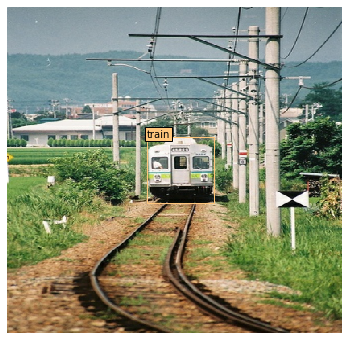

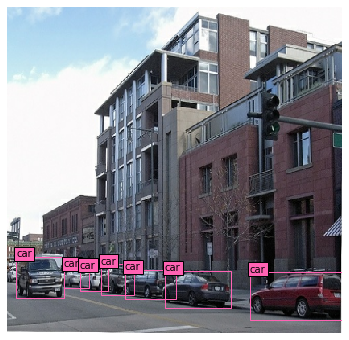

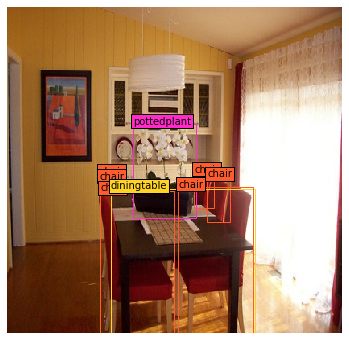

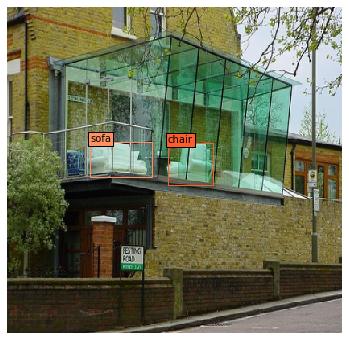

In [6]:
for imgs, labels, names in data.take(2):
    print('label shape: ', labels.shape)
    for img, label in zip(imgs, labels):
        
        shape = img.shape
        shape = [shape[0] // 32, shape[1]//32]
        # convert the labels back to a list of boxes
        bboxList = label2Box(label, shape, loader.anchors)
        bboxList = np.squeeze(bboxList)
        newDim = img.shape
        # box list has shape (num box, 5), the last dimension is 
        # (left, top, bottom, right, obj id) normalized between 0 and 1
        bboxList = bboxList.reshape(-1, 5)
        classList = [int(bbox[0]) for bbox in bboxList]
        # scale the box back to image scale
        bboxList = [ [bbox[1]*newDim[1], bbox[2]*newDim[0],
                  bbox[3]*newDim[1], bbox[4]*newDim[0]] for bbox in bboxList]
        painter.drawBox(img, bboxList, classes=classList)